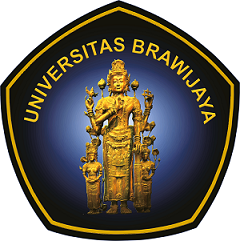

### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">Implementasi Naive Bayes di Pabrik Sabun Cair sebagai proses Quality Control</p>

### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENT</p>

* [1. IMPORT LIBRARY](#1)
    
* [2. DATA EXPLORATION](#2)

* [3. PREPARING DATASET AND FEATURE EXTRACTION(MFCC)](#3) 
    
* [4. SVM CLASSIFICATION](#4)  

<a id="1"></a>
#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">1. IMPORT LIBRARY</p>

In [46]:
# Basic Library
import warnings
import os
import numpy as np
import pandas as pd

# Machine Learning Library
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Visualization Library
import matplotlib.pyplot as plt
import seaborn as sns

# Dimentionality Reduction & Normalization Library
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Model Evaluation Library
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

<a id="2"></a>
#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">2. IMPORT DATASET</p>

In [47]:
df = pd.read_excel('dataset.xlsx')

In [48]:
df.head()

,Red,Green,Blue,Clear,MQ3,Kelas
0,196,276,284,806,382,Merah
1,199,279,288,816,373,Merah
2,201,282,290,823,395,Merah
3,209,291,300,851,392,Merah
4,210,292,301,853,372,Merah


In [49]:
df.shape

(60, 6)

<a id="3"></a>
#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">3. EXPLORATORY DATA ANALYSIS</p>

In [50]:
kelas_merah = df[df['Kelas'] == 'Merah']
kelas_kuning = df[df['Kelas'] == 'Kuning']
kelas_biru = df[df['Kelas'] == 'Biru']

In [51]:
red = df.loc[:, 'Red']
green = df.loc[:, 'Green']
blue = df.loc[:, 'Blue']
red = red.to_numpy()
green = green.to_numpy()
blue = blue.to_numpy()

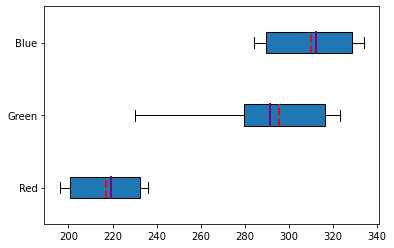

In [52]:
# Kelas Merah

fig, ax = plt.subplots()
ax.boxplot((kelas_merah.loc[:, 'Red'], 
            kelas_merah.loc[:, 'Green'], 
            kelas_merah.loc[:, 'Blue']), 
            vert=False, showmeans=True, meanline=True,
            labels=('Red', 'Green', 'Blue'), patch_artist=True,
medianprops={'linewidth': 2, 'color': 'purple'},
meanprops={'linewidth':2, 'color': 'red'})
plt.show()

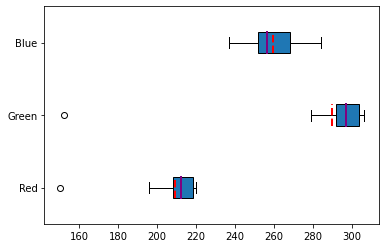

In [53]:
# Kelas Kuning

fig, ax = plt.subplots()
ax.boxplot((kelas_kuning.loc[:, 'Red'], 
            kelas_kuning.loc[:, 'Green'], 
            kelas_kuning.loc[:, 'Blue']), 
            vert=False, showmeans=True, meanline=True,
            labels=('Red', 'Green', 'Blue'), patch_artist=True,
medianprops={'linewidth': 2, 'color': 'purple'},
meanprops={'linewidth':2, 'color': 'red'})
plt.show()

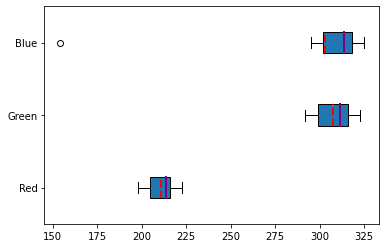

In [54]:
# Kelas Biru

fig, ax = plt.subplots()
ax.boxplot((kelas_biru.loc[:, 'Red'], 
            kelas_biru.loc[:, 'Green'], 
            kelas_biru.loc[:, 'Blue']), 
            vert=False, showmeans=True, meanline=True,
            labels=('Red', 'Green', 'Blue'), patch_artist=True,
medianprops={'linewidth': 2, 'color': 'purple'},
meanprops={'linewidth':2, 'color': 'red'})
plt.show()

In [55]:
def detect_outliers(df, x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3-Q1
    return df[(df[x] < Q1-1.5*IQR) | (df[x] > Q3+1.5*IQR)]

In [56]:
detect_outliers(df, 'Green')

,Red,Green,Blue,Clear,MQ3,Kelas
16,236,230,331,940,450,Merah
30,150,152,277,879,820,Kuning


In [57]:
detect_outliers(df, 'Blue')

,Red,Green,Blue,Clear,MQ3,Kelas
40,205,299,154,856,602,Biru


In [58]:
df = df.drop(detect_outliers(df, 'Green').index)

In [59]:
df = df.drop(detect_outliers(df, 'Blue').index)

In [60]:
df.shape

(57, 6)

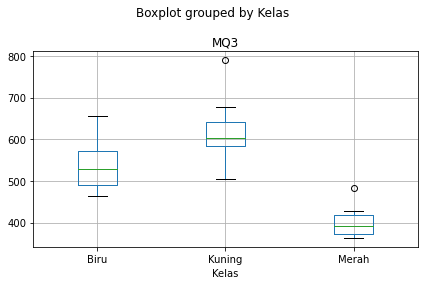

In [20]:
df.boxplot(column=['MQ3'], by='Kelas')
plt.tight_layout()

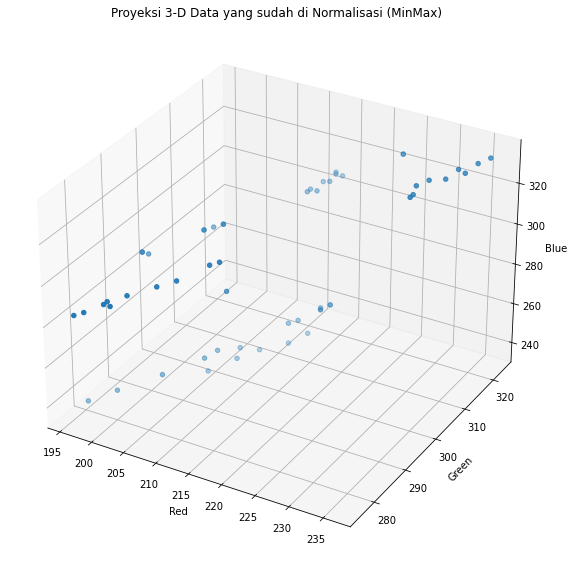

In [22]:
# A 3D Projection Of Data In The Reduced Dimension
x = df.loc[:, 'Red']
y = df.loc[:, 'Green']
z = df.loc[:, 'Blue']

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d", label='Kelas')
scatter_plot = ax.scatter(x,y,z, marker="o" )
ax.set_title("Proyeksi 3-D Data yang sudah di Normalisasi (MinMax)")



ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

plt.tight_layout()
plt.show()

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">Feature Importance (FT)</p>

Feature Importance adalah inbuilt class bawaan dari Tree Based Classifier, kami akan gunakan Extra Tree Classifier untuk mengetahui fitur mana yang memiliki kepentingan sangat besar.

Feature Importance akan memberikan skor untuk setiap fitur data, semakin tinggi skor maka semakin relevan fitur tersebut terhadap variabel output.

sumber : https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

X_ft = df.loc[:, ['Red', 'Green', 'Blue', 'Clear', 'MQ3']]
y_ft = df.loc[:, 'Kelas']

model = ExtraTreesClassifier()
model.fit(X_ft, y_ft)

ExtraTreesClassifier()

In [24]:
print(model.feature_importances_)

[0.16083467 0.12303824 0.33793283 0.10496348 0.27323079]


<AxesSubplot:>

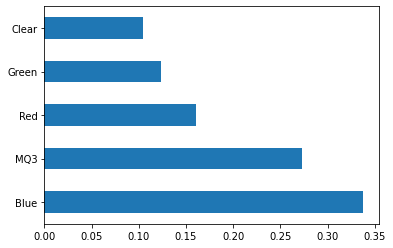

In [25]:
feat_importances = pd.Series(model.feature_importances_, index=X_ft.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">Pearson Correlation Matrix</p>

<AxesSubplot:>

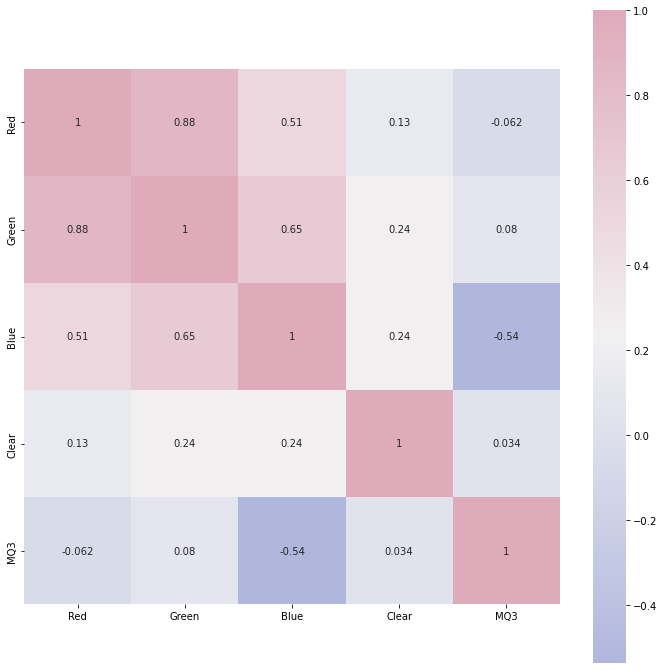

In [26]:
corrmat = df.corr()
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat,cmap= cmap,annot=True, square=True)

<a id="3"></a>
#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">3. TRAINING & TEST DATA SPLIT</p>

In [27]:
X = df.loc[:, ['Red', 'Green', 'Blue', 'Clear', 'MQ3']]
y = df.loc[:, 'Kelas']

# Karena banyak tools yang mewajibkan kita menggunakan numpy array, maka kita ubah X dan y menjadi array
#X = X.to_numpy()
#y = y.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">Min-Max Scaler (Normalization)</p>

https://medium.com/coderbyte/how-to-normalize-the-data-in-python-18a1cbc47ec1

In [28]:
scaler = MinMaxScaler()

# Penting untuk melakukan fit pada train data, bukan test
scaler.fit(X_train)  

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">PCA</p>

https://www.geeksforgeeks.org/principal-component-analysis-with-python/

In [29]:
X_train.head()

,Red,Green,Blue,Clear,MQ3
27,219,305,268,842,640
42,204,299,302,856,572
38,216,301,254,822,598
10,236,323,334,947,427
52,217,316,318,904,557


In [30]:
# Initiating PCA to reduce dimentionality
pca = PCA(n_components=3)
pca.fit(X_train)
pca_X_train = pd.DataFrame(pca.transform(X_train), columns=(["col1","col2", "col3"]))
pca_X_test = pd.DataFrame(pca.transform(X_test), columns=(["col1","col2", "col3"]))

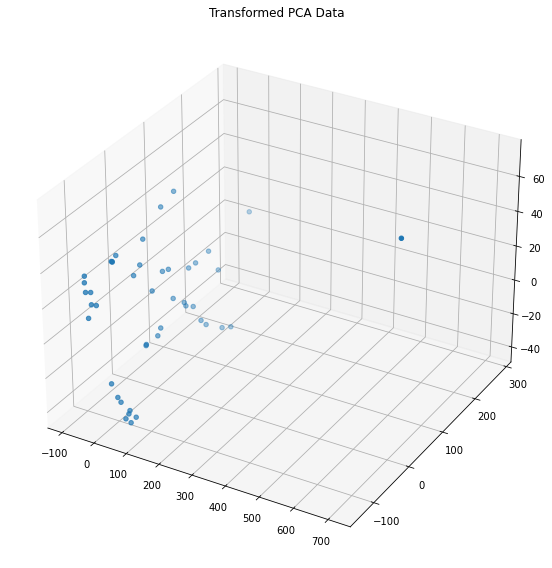

In [31]:
# A 3D Projection Of Data In The Reduced Dimension
x = pca_X_train.loc[:, 'col1']
y = pca_X_train.loc[:, 'col2']
z = pca_X_train.loc[:, 'col3']

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
scatter_plot = ax.scatter(x,y,z, marker="o" )
ax.set_title("Transformed PCA Data")



#ax.set_xlabel('Red')
#ax.set_ylabel('Green')
#ax.set_zlabel('Blue')

plt.tight_layout()
plt.show()

<a id="3"></a>
#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">4. GAUSSIAN NAIVE BAYES</p>

https://towardsdatascience.com/naive-bayes-classifier-how-to-successfully-use-it-in-python-ecf76a995069

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">I. Raw Data (Red, Green, Blue, MQ3) without Normalization</p>

In [32]:
clf_raw = GaussianNB()
clf_raw.fit(X_train, y_train)
model_prediction_raw = clf_raw.predict(X_test)

In [33]:
print(classification_report(y_test, model_prediction_raw))

              precision    recall  f1-score   support

        Biru       1.00      1.00      1.00         6
      Kuning       1.00      1.00      1.00         4
       Merah       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



[Text(0.5, 15.0, 'Prediksi'), Text(33.0, 0.5, 'Input Suara')]

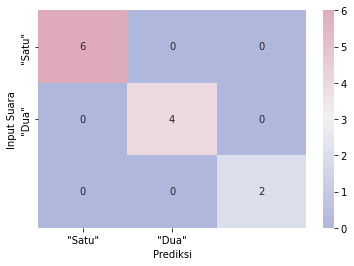

In [34]:
results = confusion_matrix(y_test, model_prediction_raw)
results
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
ax = sns.heatmap(results, annot=True, cmap=cmap, xticklabels=['"Satu"', '"Dua"'], yticklabels=['"Satu"', '"Dua"'] )
ax.set(xlabel='Prediksi', ylabel='Input Suara')

Matriks Konfusi

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">II. Model with Normalized Data (Red, Green, Blue, MQ3)</p>

In [35]:
clf_scaled = GaussianNB()
clf_scaled.fit(X_train_scaled, y_train)
model_prediction_scaled = clf_scaled.predict(X_test_scaled)

In [36]:
print(classification_report(y_test, model_prediction_scaled))

              precision    recall  f1-score   support

        Biru       1.00      1.00      1.00         6
      Kuning       1.00      1.00      1.00         4
       Merah       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



[Text(0.5, 15.0, 'Prediksi'), Text(33.0, 0.5, 'Input Suara')]

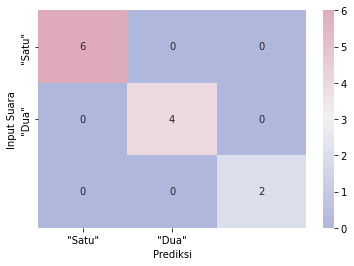

In [37]:
results = confusion_matrix(y_test, model_prediction_scaled)
results
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
ax = sns.heatmap(results, annot=True, cmap=cmap, xticklabels=['"Satu"', '"Dua"'], yticklabels=['"Satu"', '"Dua"'] )
ax.set(xlabel='Prediksi', ylabel='Input Suara')

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">III. Model with PCA Transformed Data (n_components = 3)</p>

In [38]:
clf_pca = GaussianNB()
clf_pca.fit(pca_X_train, y_train)
model_prediction_pca = clf_pca.predict(pca_X_test)

In [39]:
print(classification_report(y_test, model_prediction_pca))

              precision    recall  f1-score   support

        Biru       1.00      0.83      0.91         6
      Kuning       0.80      1.00      0.89         4
       Merah       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.93      0.94      0.93        12
weighted avg       0.93      0.92      0.92        12



[Text(0.5, 15.0, 'Prediksi'), Text(33.0, 0.5, 'Input Suara')]

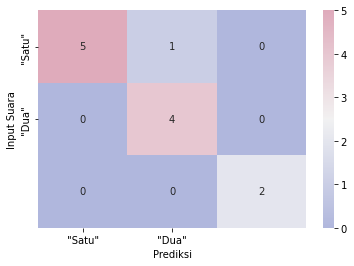

In [40]:
results = confusion_matrix(y_test, model_prediction_pca)
results
cmap = sns.diverging_palette(260,-10,s=50, l=75, n=6, as_cmap=True)
ax = sns.heatmap(results, annot=True, cmap=cmap, xticklabels=['"Satu"', '"Dua"'], yticklabels=['"Satu"', '"Dua"'] )
ax.set(xlabel='Prediksi', ylabel='Input Suara')

#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">Mencoba di Sabun Campuran</p>

Kita load file excel yang berisi dataset dengan sabun yang sudah dicampur.

In [41]:
# Load the file
df = pd.read_excel('dataset - sabun campuran.xlsx')

# Getting the feature
X_campuran = df.loc[:, ['Red', 'Green', 'Blue', 'Clear', 'MQ3']]
X_campuran = X_campuran.to_numpy()

In [42]:
X_campuran[0].shape

(5,)

*predict_proba* disini sangat penting untuk projek kami. predict_proba adalah function bawaan dari scikit-learn yang akan menampilkan probabilitas dari semua klasifikasi.

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    campuran = (clf_raw.predict_proba(X_campuran[2].reshape(1, -1))).flatten()

print(campuran)

[0.00109511 0.90313918 0.09576572]


In [44]:
# Urutkan dari terkecil => terbesar
campuran.sort()

# Ambil probabilitas terbesar diurutan [-1]
if campuran[-1] < 0.97:
    print("Probabilitas kelas tertinggi: {0:.3f}, \nsehingga produk tidak memenuhi standard.".format(campuran[-1]))
else:
    print("Probabilitas kelas tertinggi: {0:.3f}, \nsehingga Produk Memenuhi Standard.".format(campuran[-1]))
    
    

Probabilitas kelas tertinggi: 0.903, 
sehingga produk tidak memenuhi standard.


In [ ]:
def predict_data(x):
    probabilitas = (clf_raw.predict_proba(x.reshape(1, -1))).flatten()
    
    probabilitas.sort()
    
    return probabilitas

<a id="3"></a>
#### <p style="background-color:#25316D;font-family:newtimeroman;color:#FEF5AC;font-size:150%;text-align:center;border-radius:10px 10px;">4. DEPLOYMENT</p>

Hasil model ML diubah ke file .pickle, sehingga tidak perlu melakukan training dari awal.

For saving to pickle:
https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

In [ ]:
import pickle

In [ ]:
# Untuk komunikasi serial dengan ESP32

import serial
import time

arduino = serial.Serial(port='COM3', baudrate=115200, timeout=0.7)

def write_read(x):
    arduino.write(bytes(x, 'utf-8'))
    time.sleep(0.05)
    data = arduino.readline()
    return data

while True:
    num = input("Enter a number: ") # Taking input from user
    value = write_read(num)
    print(value) # printing the value

In [ ]:
# Numpy array for data placeholder
input_data = np.empty(0, dtype=int)

while True:
    command = input("Enter a command: ") # Taking input from user
    
    if command == "red":              # request data = red
        value = write_read("1")
        value = value.decode('utf-8')
        input_data = np.insert(input_data, 0, value)
        print(f"Nilai Red: {value}\n")
        
    elif command == "green":          # request data = green
        value = write_read("2")
        value = value.decode('utf-8')
        input_data = np.insert(input_data, 1, value)
        print(f"Nilai Green: {value}\n")
        
    elif command == "blue":           # request data = blue
        value = write_read("3")
        value = value.decode('utf-8')
        input_data = np.insert(input_data, 2, value)
        print(f"Nilai Blue: {value}\n")
        
    elif command == "mq3":            # request data = mq3
        value = write_read("4")
        value = value.decode('utf-8')
        input_data = np.insert(input_data, 3, value)
        print(f"Nilai sensor MQ3: {value}\n")
    
    elif command == "show_data":
        print(input_data)
        
    elif command == "predict":
        prob = predict_data(input_data)
        if campuran[-1] < 0.97:
            print("Probabilitas kelas tertinggi: {0:.3f}, \nsehingga produk tidak memenuhi standard.".format(campuran[-1]))
        else:
            print("Probabilitas kelas tertinggi: {0:.3f}, \nsehingga Produk Memenuhi Standard.".format(campuran[-1])) 
    else:
        print(value) # printing the value

In [ ]:
print(input_data)